In [251]:
# fastai imports
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [252]:
# pytorch imports
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd

Read in the dataset and prepare the dataset.

In [253]:
# read the file with pandas, the file is tab seperated with columns: 'user','movie','rating','timestamp'
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [254]:
# we can use the items dataset to see movie titles
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [255]:
# merge with ratings to see user ratings for titles
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [69]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,606,Grease (1978),3
1,505,"Little Princess, A (1995)",3
2,903,"Great White Hype, The (1996)",3
3,532,Wyatt Earp (1994),4
4,181,Jungle2Jungle (1997),1
5,339,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",4
6,43,Ransom (1996),5
7,848,Apocalypse Now (1979),2
8,627,"Time to Kill, A (1996)",2
9,798,Race the Sun (1996),4


In [70]:
# uncomment below to see printout of classes, will see the different users and movies
# dls.classes

Initialize embeddings randomly.

In [71]:
n_users  = len(dls.classes['user']) # number of users
n_movies = len(dls.classes['title']) # number of titles
n_factors = 5 # number of latent factors we want to learn

user_factors = torch.randn(n_users, n_factors) # intialize random embeddings for each user, matrix of size n_users * n_factors
movie_factors = torch.randn(n_movies, n_factors) # intialize random embeddings for each movie, matrix of size n_movies * n_factors
user_factors

tensor([[ 4.9188e-01, -1.4135e+00, -2.3865e-01, -1.3885e+00, -5.3980e-04],
        [ 6.5869e-02, -3.4996e-01, -1.6828e+00,  8.9334e-02,  8.4842e-01],
        [ 9.3569e-01,  1.4106e-01,  7.0103e-01,  5.9255e-01,  9.0271e-01],
        ...,
        [-1.6914e-01, -1.0857e+00,  3.7300e-01, -5.7337e-01, -9.4853e-01],
        [-1.0122e+00,  3.7673e-01, -1.9000e+00, -2.3160e-02, -7.4045e-02],
        [ 8.8319e-01, -2.6054e+00, -1.2205e+00, -4.5769e-01, -1.8013e+00]])

In [72]:
# we a way to look up the embeddings for different users and movies
# we can use one hot encoding and matrix multiplication
one_hot_4 = one_hot(4, n_users).float() # vector with all 0's but a 1 at index 4

user_factors.t() @ one_hot_4 # gives us the same vector at index 4

tensor([-0.3934, -0.0248,  0.4584, -1.5631, -0.8732])

In [73]:
user_factors[4]

tensor([-0.3934, -0.0248,  0.4584, -1.5631, -0.8732])

A matrix of one hot encoded vectors will take up too much space - not time and memory efficient. We want to be able to index directly.

Pytorch handles this with an embedding matrix. Pytorch multiplies by a one-hot-encoded matrix, using the computational shortcut that it can be implemented by simply indexing directly.

In [74]:
# Inherit from module to create a dot product model class
# define layers and operations

class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        # generate embeddings for users and movies
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)

    def forward(self, x):
        # x has shape batch size x 2
        users = self.user_factors(x[:,0]) # column 0 contains user ids
        movies = self.movie_factors(x[:,1]) # column 1 column 1 contains mvoie ids
        return (users * movies).sum(dim=1) # dot product

In [75]:
# Define the model and the learner
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [76]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.302967,1.311777,00:12
1,1.057212,1.099804,00:11
2,0.931564,0.999986,00:11
3,0.760246,0.914547,00:11
4,0.767924,0.890176,00:12


In [77]:
# add in a sigmoid activation function to control the range of rating output calculated
# ratings are on a scale of 0-5 so we say y_range=(0,5.5)
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [78]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.898023,0.985058,00:12
1,0.667042,0.963085,00:11
2,0.448009,0.964451,00:11
3,0.361598,0.967046,00:12
4,0.332875,0.964631,00:11


We have weights but we need biases. We need a number for each user and each movie that we can add to our score that reflects how positive the user or movie is.


In [79]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True) # dot product of embeddings
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1]) # add on user and movie bias
        return sigmoid_range(res, *self.y_range)

In [80]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.852548,0.934250,00:12
1,0.591490,0.903862,00:12
2,0.401973,0.937617,00:12
3,0.322735,0.952601,00:12
4,0.291531,0.954086,00:12


Add L2 regularization to prevent overfitting

In [81]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.908215,0.948438,00:12
1,0.675650,0.902728,00:12
2,0.525382,0.871554,00:12
3,0.483290,0.864301,00:12
4,0.444529,0.859659,00:12


We can also write a function to initialize our own embeddings.

In [82]:
# return a tensor of size that is a nn paramter
# it needs to return a nn parameter so that the module treats it as a parameter
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [83]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [84]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.860565,0.954250,00:12
1,0.678279,0.890010,00:12
2,0.510067,0.869874,00:12
3,0.460625,0.854438,00:12
4,0.449025,0.850009,00:12


Interpret Model Results

In [85]:
# Movies with the highest bias
# These are the movies that people would probably like, regardless of if they like movies of this kind
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 "Schindler's List (1993)",
 'Usual Suspects, The (1995)',
 'Star Wars (1977)',
 'Shawshank Redemption, The (1994)']

In [91]:
movie_factors = learn.model.movie_factors
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]
# the output is penny seranade - this movie is not at all similar to silence of the lambs

'Penny Serenade (1941)'

Principal Component Analysis

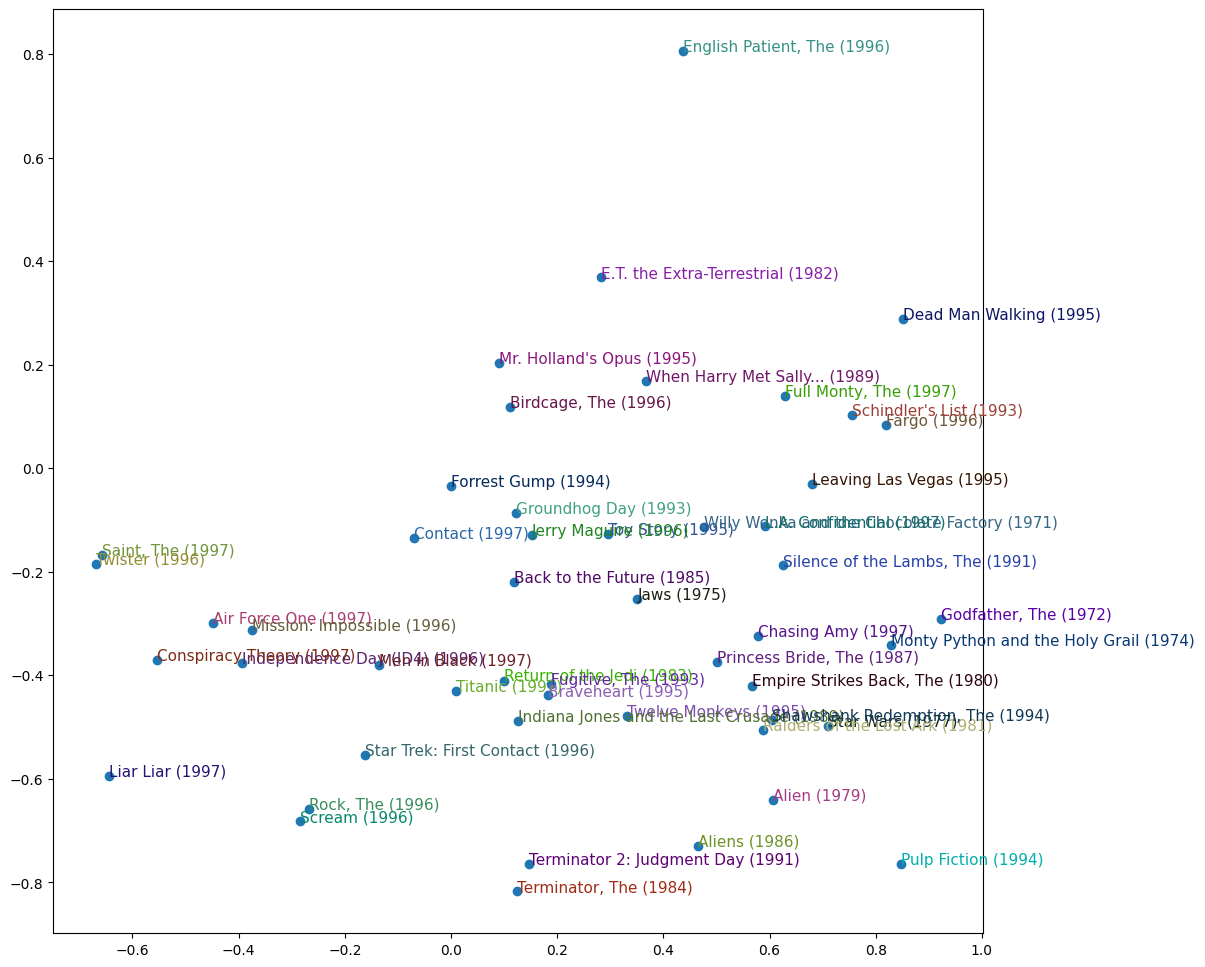

In [92]:
#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

Movies close to each other likely appeal to similar audiences, as they share more common characteristics in terms of viewer preferences.
Movies far apart are less likely to be enjoyed by the same users, indicating that their content, genre, or appeal differs significantly.

That approach was probabilistic matrix factorization, now try deep learning.

In [93]:
# get embedding size using fastai heuristic
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [94]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range

    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [95]:
model = CollabNN(*embs)

In [96]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.934023,0.954265,00:14
1,0.869734,0.919302,00:14
2,0.806325,0.895314,00:14
3,0.773444,0.881680,00:15
4,0.744896,0.874018,00:15


In [97]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.972073,0.977197,00:19
1,0.892381,0.938517,00:16
2,0.806667,0.899516,00:16
3,0.796182,0.872710,00:16
4,0.751150,0.871888,00:16


In [126]:
import torch.nn.init as init

In [127]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100, dropout_p=0.5):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.user_bias = nn.Embedding(user_sz[0], 1)
        self.item_bias = nn.Embedding(item_sz[0], 1)

        # Initialize embeddings with normal distribution
        init.normal_(self.user_factors.weight, mean=0, std=0.01)
        init.normal_(self.item_factors.weight, mean=0, std=0.01)

        # You can also initialize bias terms if needed
        init.normal_(self.user_bias.weight, mean=0, std=0.01)
        init.normal_(self.item_bias.weight, mean=0, std=0.01)

        self.layers = nn.Sequential(
            nn.Linear(user_sz[1] + item_sz[1], n_act),
            nn.BatchNorm1d(n_act),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(n_act, 1)
        )
        self.y_range = y_range

    def forward(self, x):
        # Ensure user and item IDs are of type Long for the embedding layer
        user_ids = x[:, 0].long()  # Ensure Long type for embeddings
        item_ids = x[:, 1].long()  # Ensure Long type for embeddings

        # Get embeddings (these are float tensors by default)
        user_emb = self.user_factors(user_ids)   # Embedding lookup (batch_size, n_factors)
        item_emb = self.item_factors(item_ids)   # Embedding lookup (batch_size, n_factors)

        # Concatenate embeddings (works on Float tensors)
        embs = torch.cat([user_emb, item_emb], dim=1)  # Should be (batch_size, n_factors * 2)

        # Pass through the MLP (ensure correct input size for Linear layer)
        x = self.layers(embs)  # Output should be (batch_size, 1)

        # Get biases (these are also Float tensors)
        user_bias = self.user_bias(user_ids).squeeze()  # Squeeze to remove extra dimension
        item_bias = self.item_bias(item_ids).squeeze()

        # Add the biases (all tensors are now Float dtype)
        # Make sure the biases match the size of `x` in the first dimension (batch_size)
        x = x.squeeze()  # Ensure x is squeezed to match bias dimensions
        x = x + user_bias + item_bias

        # Apply sigmoid range transformation
        return sigmoid_range(x, *self.y_range)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.963964,0.988603,00:15
1,0.853787,0.953445,00:16
2,0.798671,0.896137,00:16
3,0.776917,0.897780,00:16
4,0.747297,0.899415,00:16
5,0.711426,0.898108,00:16
6,0.685441,0.894722,00:16
7,0.652317,0.895603,00:16
8,0.658851,0.894590,00:15
9,0.659613,0.897633,00:15


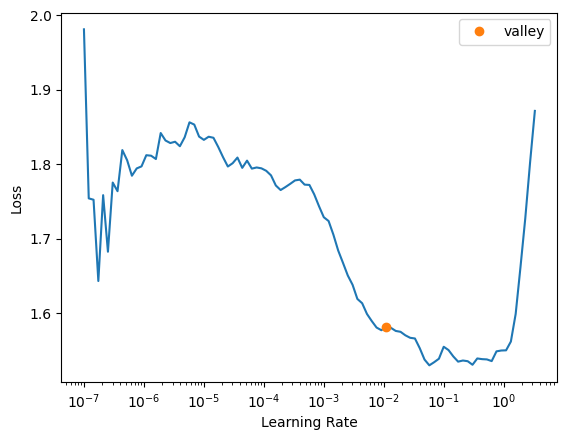

In [128]:
# Initialize the model
model = CollabNN(*embs, n_act=100, dropout_p=0.2)

# Create the Learner
learn = Learner(dls, model, loss_func=MSELossFlat())

# Find optimal learning rate
learn.lr_find()

# Train using the 1cycle policy
learn.fit_one_cycle(10, 5e-3, wd=0.01)

In [129]:
# Try different values of weight decay
for wd in [1e-6, 1e-5, 1e-4, 1e-3]:
    print(f'Training with weight decay: {wd}')
    learn.fit_one_cycle(5, 1e-2, wd=wd)

Training with weight decay: 1e-06


epoch,train_loss,valid_loss,time
0,0.737735,0.908950,00:16
1,0.724912,0.915436,00:17
2,0.700508,0.907199,00:17
3,0.658822,0.905501,00:16
4,0.626027,0.901181,00:16


Training with weight decay: 1e-05


epoch,train_loss,valid_loss,time
0,0.692892,0.943533,00:15
1,0.710344,0.934040,00:18
2,0.643682,0.933300,00:16
3,0.608579,0.929724,00:16
4,0.593881,0.921051,00:16


Training with weight decay: 0.0001


epoch,train_loss,valid_loss,time
0,0.646243,0.953508,00:17
1,0.628183,0.952618,00:16
2,0.623408,0.953449,00:16
3,0.587430,0.940775,00:16
4,0.567066,0.939343,00:16


Training with weight decay: 0.001


epoch,train_loss,valid_loss,time
0,0.595355,0.971099,00:17
1,0.640239,0.955550,00:16
2,0.594753,0.969482,00:16
3,0.556170,0.959737,00:16
4,0.539405,0.954361,00:17


In [231]:
learn = collab_learner(dls, n_factors=80, y_range=(0, 5.5))

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.010964781977236271)

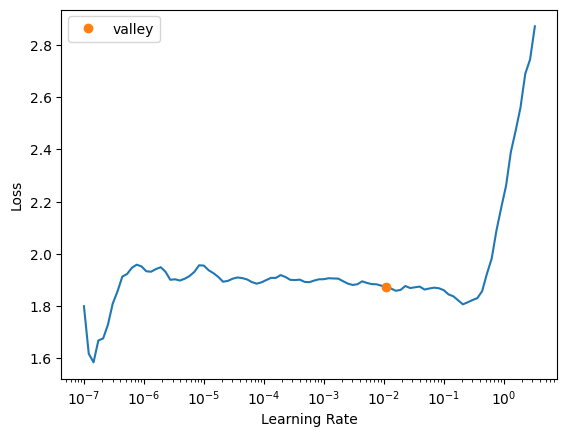

In [232]:
learn.lr_find()

Pick a user_id that is not presented in the datasets (99999) and then rate some movies, then add the user to the main dataframe.

In [261]:
rows = []
user_id = 99999
movies = ['Titanic (1997)',
 'Star Wars (1977)',
 'Shawshank Redemption, The (1994)',
 'L.A. Confidential (1997)',
 'Silence of the Lambs, The (1991)']
movie_ratings = [4, 5, 3, 4, 4]
for i in range(len(movies)):
    rows.append( dict( {'title' : movies[i], 'user' : user_id, 'rating' : movie_ratings[i]}))

user_data = pd.DataFrame(rows)
ratings = pd.concat([ratings, user_data], axis=0)
ratings = data[['user', 'title', 'rating']]
ratings.head()

TypeError: 'module' object is not subscriptable

In [236]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.191178,0.977222,00:12
1,0.255599,0.941167,00:12
2,0.220888,0.922413,00:12
3,0.175178,0.909243,00:12
4,0.159143,0.909083,00:11


In [191]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 80)
  (i_weight): Embedding(1665, 80)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [195]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Titanic 1997)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Symphonie pastorale, La (1946)'

This kind of makes sense since they are both dramas and kind of sad. Use the model to reccomend the movies a user would like.

In [209]:
learn.validate()

(#1) [0.8725353479385376]

In [226]:
rows = []
movies = list(ratings.drop_duplicates(subset='title', keep='first').title)
names = list(ratings.drop_duplicates(subset='user', keep='first').user)
for i in range(len(movies)):
    rows.append( dict({'name': names[i], 'movie_id' : movies[i], 'user_id' : 99999}))
test_data = pd.DataFrame(rows)

# Load your model
data_collab = CollabDataBunch.from_df(data_reduced, test=test_data, seed=42, valid_pct=0.2, user_name='user', item_name='title', rating_name='rating')
learn = collab_learner(data_collab, n_factors=40, y_range=(0, 10), wd=1e-2)
learn_loaded = learn.load(Path('/content/drive/My Drive/kaggle/MovieTweeting/trained_model'))

TypeError: save() got an unexpected keyword argument 'return_path'